<p>
Prepared by Vytautas Bielinskas. 2020. <br>
Download data from: https://finance.yahoo.com/quote/GOOG/history/
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

import requests
import io

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [62]:
# Importing Training Set
url="https://iaq-data.brgr.rocks/full.csv"
s=requests.get(url).content
dataset_train = data=pd.read_csv(io.StringIO(s.decode('utf-8')))
dataset_train.livingroom_window_open = dataset_train.livingroom_window_open.replace({True: 1, False: 0})
dataset_train.livingroom_door_open = dataset_train.livingroom_window_open.replace({True: 1, False: 0})
dataset_train.balcony_door_open = dataset_train.livingroom_door_open.replace({True: 1, False: 0})
dataset_train.kitchen_window_open = dataset_train.kitchen_window_open.replace({True: 1, False: 0})

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['timestamp'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in datelist_train]
print(dataset_train)


# Select features (columns) to be involved intro training and predictions
cols = ["co2","livingroom_window_open", "livingroom_door_open", "balcony_door_open", "kitchen_window_open"]
dataset_train = dataset_train[cols]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print(dataset_train.tail)



                       timestamp  temperature  humidity  rtemperature  \
0       2022-05-03T16:12:37.532Z        20.28     46.05         20.13   
1       2022-05-03T16:12:48.034Z        20.28     46.05         20.15   
2       2022-05-03T16:12:58.566Z        20.28     46.05         20.15   
3       2022-05-03T16:13:09.093Z        20.28     46.05         20.12   
4       2022-05-03T16:13:19.613Z        20.28     46.05         20.13   
...                          ...          ...       ...           ...   
408279  2022-06-26T03:27:11.422Z        25.28     50.26         24.95   
408280  2022-06-26T03:27:22.222Z        25.28     50.26         24.93   
408281  2022-06-26T03:27:33.326Z        25.28     50.26         24.95   
408282  2022-06-26T03:27:43.873Z        25.28     50.26         24.93   
408283  2022-06-26T03:27:54.657Z        25.28     50.26         24.93   

        rhumidity  pressure  temperature_outdoor  humidity_outdoor  \
0           45.06       950                20.14     

<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [19]:
dataset_train = dataset_train[cols].astype(str)
#for i in cols:
#    for j in range(0, len(dataset_train)):
#        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (408284, 5).


array([[606.62,   0.  ,   0.  ,   0.  ,   0.  ],
       [605.24,   0.  ,   0.  ,   0.  ,   0.  ],
       [604.32,   0.  ,   0.  ,   0.  ,   0.  ],
       ...,
       [540.83,   0.  ,   0.  ,   0.  ,   1.  ],
       [540.58,   0.  ,   0.  ,   0.  ,   1.  ],
       [539.78,   0.  ,   0.  ,   0.  ,   1.  ]])

In [20]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.19316812],
       [-0.19831466],
       [-0.20174569],
       ...,
       [-0.43852405],
       [-0.4394564 ],
       [-0.4424399 ]])

In [81]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 90   # Number of days we want top predict into the future
n_past = 20     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (408175, 20, 4).
y_train shape == (408175, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [59]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import tensorflow as tf

In [68]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50))

model.add(tf.keras.layers.Dense(500))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=15)
model.compile(optimizer='adam', loss='mse')

<h3>Step #4. Start training</h3>

In [69]:
history = model.fit(X_train, y_train, epochs=1)
model.save('model')

12756/12756 [==============================] - 202s 15ms/step - loss: 0.1130


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [82]:
n_future_new = 90000

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future_new, freq='10s').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.isoformat())


<h3>Step #5. Make predictions for future dates</h3>

In [83]:

# Perform predictions
predictions_future = model.predict(X_train[-n_future_new:])
print(X_train.shape)
print(predictions_future.shape)

predictions_train = model.predict(X_train[n_past:])

2813/2813 [==============================] - 23s 8ms/step
(408175, 20, 4)
(90000, 1)
12755/12755 [==============================] - 106s 8ms/step


In [85]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y-%m-%dT%H:%M:%S.%f'), '%Y-%m-%dT%H:%M:%S.%f')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['co2']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['co2']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,co2
2022-05-03 16:35:14.354,660.789368
2022-05-03 16:35:24.847,661.331421
2022-05-03 16:35:35.311,663.685059


<h3>Step #6. Visualize the Predictions</h3>

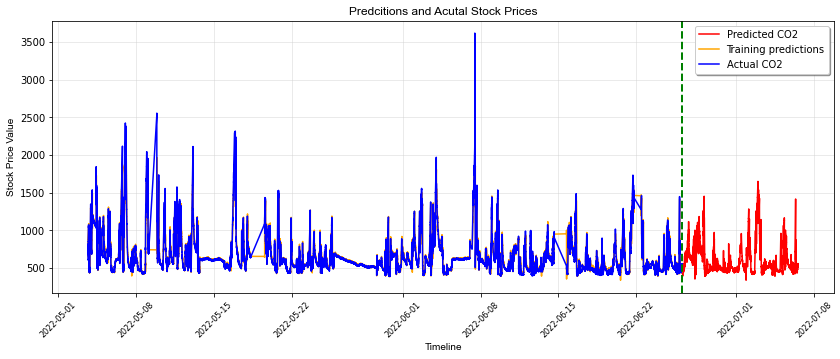

In [88]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['co2'], color='r', label='Predicted CO2')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['co2'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['co2'], color='b', label='Actual CO2')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [87]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)